In [1]:
import os
os.environ['DVC_ROOT'] = '..'
import sys
if '..' not in sys.path:
    sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.axis import Axis
from matplotlib.collections import PathCollection
import numpy as np
import json
from typing import Type

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from mock import MagicMock
from unittest.mock import patch

from stages.models.Model import Model
from stages.vectorizers.Vectorizer import Vectorizer
from stages.datacleaners.DataCleaner import DataCleaner
from stages.dataloaders.DataLoader import DataLoader

from stages.datacleaners.DummyDatacleaner import DummyDatacleaner

from stages.dataloaders.PrusVsSienkiewicz import PrusVsSienkiewicz

from stages.vectorizers.BigramMorphTagVectorizer370 import BigramMorphTagVectorizer370

from stages.models.LogisticRegression import LogisticRegression

from stages.models.AffinityPropagation import AffinityPropagation
from stages.models.DBSCAN import DBSCAN
from stages.models.KMeans import KMeans


#https://chat.openai.com/share/c8f1af4b-daef-4065-8ac6-4ff0575c1bcc

2024-04-10 10:41:44.359 | DEBUG    | utils.spacy_gpu:resolve_spacy_batch_size:47 - Spacy: resolved batch size to 500 (default) since NO env var present.


In [8]:
def save_json_results(self, dataset: str, datacleaner: str, vectorizer: str, params_name: str,
                      params: dict[str, str | int | float], metrics: dict[str, float]) -> None:
        dirs_in_path = ["results", dataset, datacleaner, vectorizer, self.__class__.__name__]
        path = '.'
        print(path)

        for p in dirs_in_path:
            path = os.path.join(path, p)
            if not os.path.exists(path):
                os.makedirs(path)

        filename = f"{params_name}.json"
        results = {'params': params, 'metrics': metrics, 'dataset': dataset, 'datacleaner': datacleaner,
                   'vectorizer': vectorizer, 'params_name': params_name}
        with open(os.path.join(path, filename), 'w') as file:
            json.dump(results, file)


def log_clusters_plot(x: np.ndarray, labels: np.ndarray, reduction_method='PCA', data_out=None):
    reducer = get_reducer(reduction_method)
    x_reduced = reducer.fit_transform(x)
    if data_out is not None:
         data_out.append(x_reduced)
         data_out.append(labels)

    fig, ax = plt.subplots(figsize=(8, 6))

    for label in np.unique(labels):
        cluster = x_reduced[labels == label]
        ax.scatter(cluster[:, 0], cluster[:, 1], label=str(label), alpha=0.4)
    ax.set_title(f'Clustering\n({reduction_method} reduction)')
    ax.legend()


def get_reducer(name: str):
    reducers = {
        'PCA': PCA(n_components=2),
        'TSNE': TSNE(n_components=2),
        'UMAP': UMAP(n_components=2)
    }
    return reducers[name]


def log_confusion_matrix_plot(conf_matrix: np.ndarray, data_out=None):
    """Plot confusion matrix."""
    if data_out is not None:
         data_out.append(conf_matrix)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_title('Macierz pomyłek')
    ax.set_xlabel('przewidziane wartości')
    ax.set_ylabel('poprawne wartości')


X_DATA, Y_DATA = None, None
def log_figure(fig: Figure, path):
     ...

In [9]:
@patch('utils.metrics.classification._log_confusion_matrix_plot')
@patch('utils.metrics.clusterization._log_clusters_plot')
@patch('utils.mlflow.experiments.mlflow_context')
@patch('utils.mlflow.experiments._resolve_experiment_id')
@patch('utils.mlflow.experiments._zip_mlflow_output')
@patch('utils.mlflow.experiments.mlflow')
@patch('utils.metrics.clusterization.mlflow')
@patch('utils.metrics.classification.mlflow')
def run(
    ModelType: Type[Model],
    dataset: DataLoader,
    datacleaner: DataCleaner,
    vectorizer: Vectorizer,
    params_name: str,
    params: dict[str, str | int | float],
    clas_mlflow_patch: MagicMock, 
    clus_mlflow_patch: MagicMock, 
    exp_mlflow_patch: MagicMock,
    zip_mlflow_output_patch: MagicMock,
    resolve_experiment_id_patch: MagicMock, 
    mlflow_context_patch: MagicMock, 
    lcp_patch: MagicMock, 
    lcm_patch: MagicMock
) -> list[np.ndarray]:
    clus_mlflow_patch.log_figure = log_figure
    clas_mlflow_patch.log_figure = log_figure
    results = []
    lcp_patch.side_effect = lambda x, labels, reduction_method: log_clusters_plot(x, labels, reduction_method, results)
    lcm_patch.side_effect = lambda conf_matrix: log_confusion_matrix_plot(conf_matrix, results)
    ModelType.save_json_results = save_json_results
    ModelType.save_mlflow_results = MagicMock()
    kmeans = ModelType()
    kmeans.evaluate(dataset.__class__.__name__, datacleaner.__class__.__name__, vectorizer.__class__.__name__, params_name, params)
    return results

2024-04-10 10:41:44.464 | WARNING  | utils.spacy_gpu:autoconfigure_spacy_mode:36 - Environment variable GRE_SPACY_MODE not set - defaulting to 'cpu'
2024-04-10 10:41:44.467 | INFO     | utils.spacy_gpu:_use_cpu:53 - Spacy: using CPU
2024-04-10 10:41:46.087 | INFO     | stages.models.DBSCAN:evaluate:17 - Fitting DBSCAN...
2024-04-10 10:41:47.096 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:27 - Preparing plots...
2024-04-10 10:42:15.654 | INFO     | utils.metrics.clusterization:compute_clustering_metrics:31 - Clustering metrics: silhouette: 0.05708409745685584 davies_bouldin: 5.566687992140141 calinski_harabasz: 171.39694216558763
2024-04-10 10:42:39.672 | INFO     | utils.metrics.clusterization:compute_b_cubed_metrics:47 - B-Cubed metrics: bcubed_precission: 0.50544681735577 bcubed_recall: 0.5657412886029651 bcubed_f1: 0.5338971412778859


.


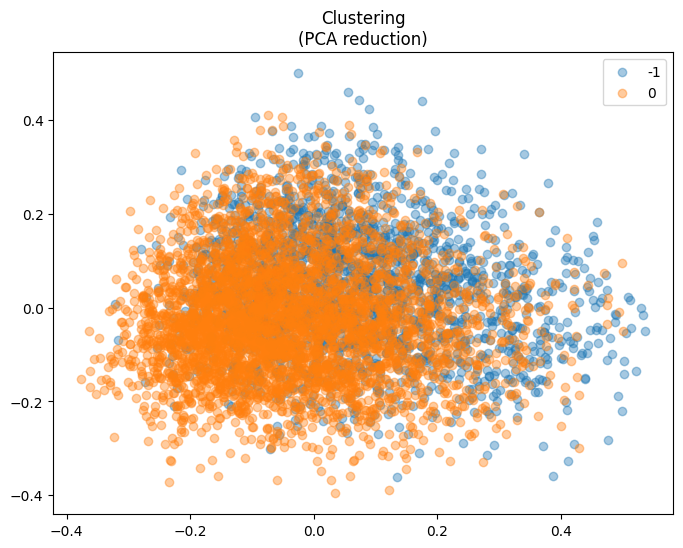

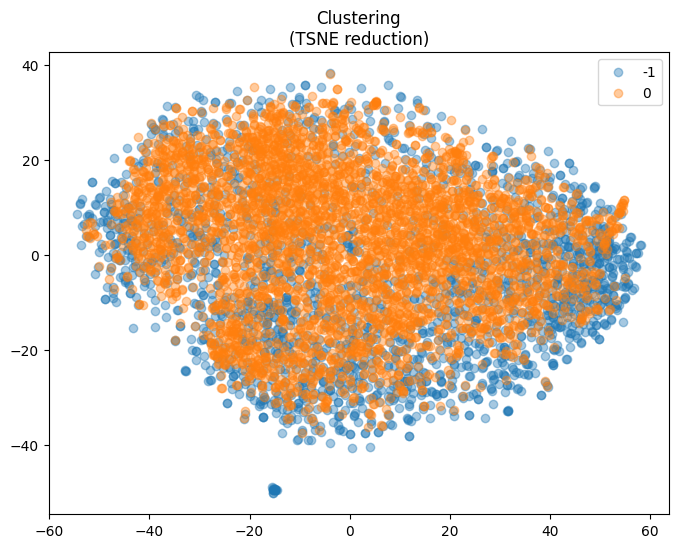

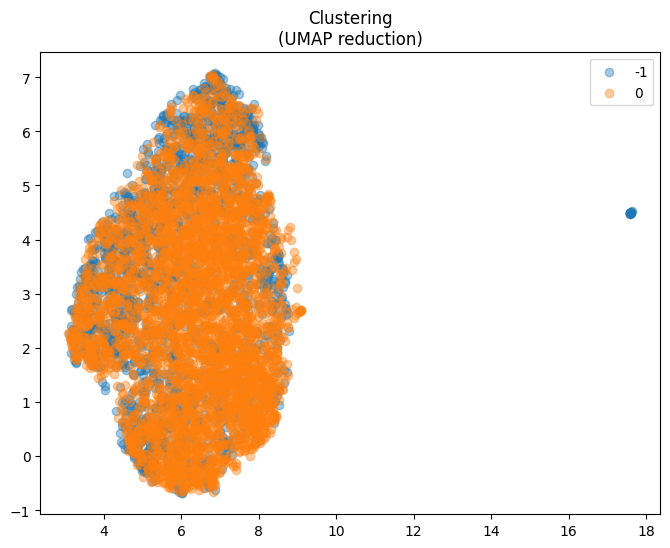

In [4]:
res = run(
    DBSCAN,
    PrusVsSienkiewicz(),
    DummyDatacleaner(),
    BigramMorphTagVectorizer370(),
    'DBSCAN',
    {}
)

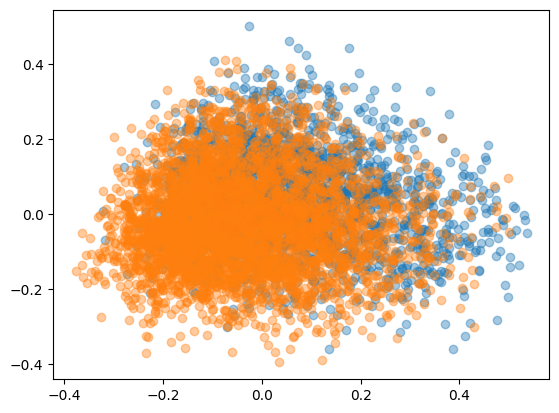

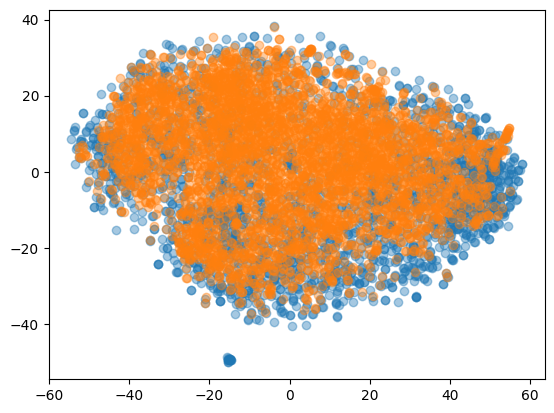

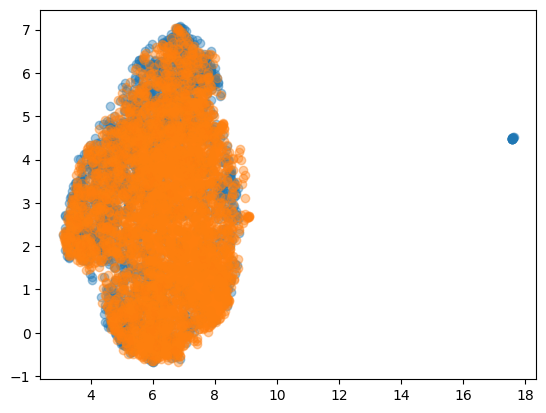

In [5]:
for data, labels in zip(res[::2], res[1::2]):
    for label in np.unique(labels):
        cluster = data[labels == label]
        plt.scatter(cluster[:, 0], cluster[:, 1], label=str(label), alpha=0.4)
    plt.show()

2024-04-10 10:46:42.780 | WARNING  | utils.spacy_gpu:autoconfigure_spacy_mode:36 - Environment variable GRE_SPACY_MODE not set - defaulting to 'cpu'
2024-04-10 10:46:42.783 | INFO     | utils.spacy_gpu:_use_cpu:53 - Spacy: using CPU
2024-04-10 10:46:44.037 | INFO     | stages.models.LogisticRegression:evaluate:21 - Fitting Logistic Regression classifier...
2024-04-10 10:46:44.038 | DEBUG    | stages.models.LogisticRegression:evaluate:22 - {}
2024-04-10 10:46:44.834 | INFO     | stages.models.LogisticRegression:evaluate:26 - Running predict...
2024-04-10 10:46:44.836 | INFO     | utils.metrics.classification:compute_classification_metrics:26 - Calculating metrics...
2024-04-10 10:46:44.872 | INFO     | utils.metrics.classification:compute_classification_metrics:52 - Result metrics: F1 = 0.697


.


[array([[208,  91],
        [170, 461]], dtype=int64)]

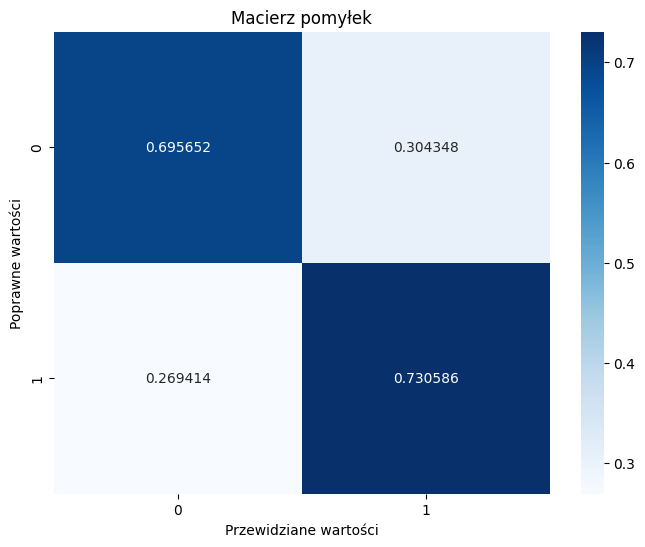

In [10]:
res = run(
    LogisticRegression, 
    PrusVsSienkiewicz(), 
    DummyDatacleaner(), 
    BigramMorphTagVectorizer370(), 
    'logistic', 
    {}
)
res